In [12]:
import importlib
importlib.reload(pcd)


NameError: name 'magpie' is not defined

In [1]:
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [8]:
rsc.disconnect()

In [3]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
# label_vit = LabelOWLViT(pth=path, topk=3)
label_vit = LabelOWLViT(pth=path, topk=3, v2=True)

2024-08-13 17:27:56.232984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 17:27:56.233039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 17:27:56.333552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 17:27:56.533976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 17:27:58.080624: W tensorflow/compiler/tf2

In [4]:
# from magpie.perception.mask_sam import MaskSAM
# ckpt = "/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"
# mask_sam = MaskSAM(ckpt)

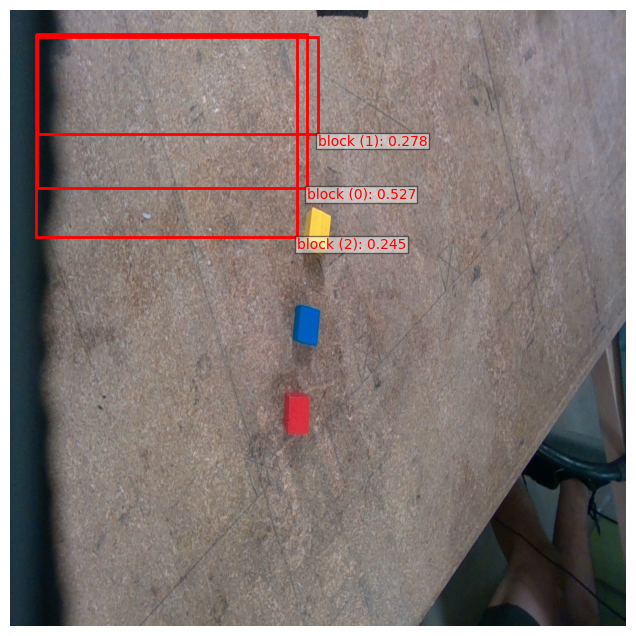

In [4]:
p, rgbd_image = rsc.getPCD()
# p, rgbd_image = rsc.getPCD(adjust_extrinsics=True)
image = np.array(rgbd_image.color)
queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
queries = ["a photo of an blue cylindrical container", "a photo of a small red cubic block", "a photo of a screwdriver handle" ]
queries = ["a photo of a black student ID card", "a photo of a small orange fruit", "a photo of a small plastic bag"]
queries = ["a photo of an avocado", "a photo of a small orange fruit", "a photo of a small plastic bag", "a photo of a paper airplane"]
queries = ["a photo of a water bottle with a red top"]
queries = ["a photo of a blue block"]
# queries = ["a photo of a tail"]
# queries = ["a photo of a black handle of a pair of scissors"]
abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
abbrevq = ["blue", "block", "handle"]
abbrevq = ["card", "orange", "bag"]
abbrevq = ["avocado", "orange", "bag", "paper airplane"]
abbrevq = ["block"]
label_vit.set_threshold(0.001)
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True, topk=True)


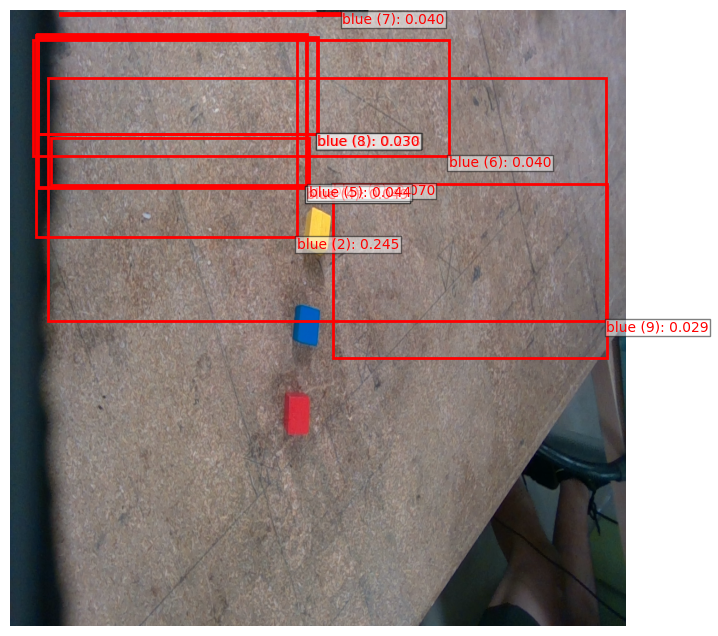

In [5]:
label_vit.TOP_K = 10
image = np.array(rgbd_image.color)
queries = ["blue"]
scores, boxes, labels = label_vit.sorted_scores, label_vit.sorted_boxes, label_vit.sorted_labels
label_vit.plot_predictions(image, queries, scores, boxes, labels, topk=True)

(720, 1280, 3)

[343.8070068359375, 229.54270935058594, 375.6669006347656, 286.24072265625, 0.27833062410354614]
[330.9307861328125, 343.55621337890625, 362.450927734375, 394.19012451171875, 0.5274903178215027]
[320.2239685058594, 446.17010498046875, 350.4136657714844, 498.6416015625, 0.24525712430477142]


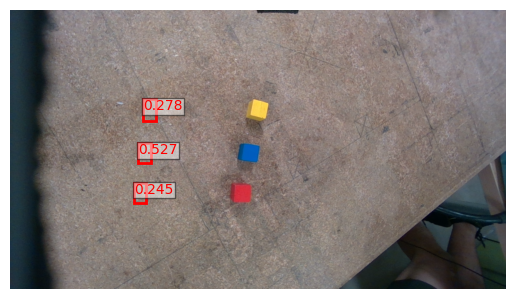

In [21]:
import matplotlib.patches as patches

img = image
# swap height and width of img
# img = np.transpose(img, (1, 0, 2))
results = label_vit.results
i = 0
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
boxes = [b.tolist() + [s] for b, s in zip(boxes, scores.tolist())]
# boxes = label_vit.sorted_boxes_coords
# boxes = [b.tolist() + [s] for b, s in zip(boxes, scores.tolist())]
fig, ax = plt.subplots(1)
ax.imshow(img)
# filter out boxes where confidence is less than 0.1
boxes = [box for box in boxes if box[-1] > 0.1]
# Add bounding boxes
for box in boxes:
    print(box)
    # multiply elementsof box by 2
    x1, y1, x2, y2, confidence = box
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{confidence:.3f}', color='red', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

plt.axis('off')
plt.show()

[588.321383   193.25037405 644.35722113 221.7319496 ]
[611.21247053 129.11778018 667.85224199 161.01039603]
[569.28702116 250.97068995 622.957623   280.48589498]
[ 5.04505539e+01 -4.05764580e-02  1.29016941e+03  4.06715906e+02]


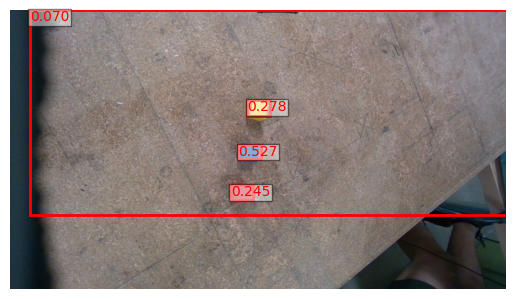

In [30]:
import matplotlib.patches as patches

img = image

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(img)
boxes = label_vit.sorted_boxes_coords
scores = label_vit.sorted_scores
# Add bounding boxes
for box, confidence in zip(boxes[:4], scores[:4]):
    x1, y1, x2, y2 = box
    width = 1.05*(x2 - x1)
    height = 1.3*(y2 - y1)
    print(box)
    rect = patches.Rectangle((x1, 1.8*y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, 1.8*y1, f'{confidence:.3f}', color='red', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

plt.axis('off')
plt.show()

In [6]:
label_vit.results[0]

tensor([260.4665,   5.4847, 268.5029,  23.9639], grad_fn=<SelectBackward0>)

In [7]:
label_vit.sorted_labeled_boxes_coords

[(array([598.03621054, 133.04095879, 665.15943766, 169.09430847]), 0),
 (array([714.5889926 , 167.06464604, 775.68063021, 198.67545292]), 0),
 (array([639.56506968, 209.76345286, 706.280725  , 244.3122603 ]), 0),
 (array([749.05323982,  84.55209285, 874.32017326, 152.23567933]), 0),
 (array([6.15347061e+02, 7.13869929e-02, 8.66977615e+02, 7.47033647e+01]), 0),
 (array([ 4.27083435e+02, -3.97675037e-01,  6.01778793e+02,  6.97742504e+01]),
  0),
 (array([ 4.57247872e+02, -3.37089300e-01,  5.44073234e+02,  3.32674062e+01]),
  0),
 (array([ 953.65805626,  340.47984838, 1175.12291908,  404.91934061]), 0),
 (array([1196.53684139,   92.01251507, 1278.17018986,  147.73954868]), 0),
 (array([749.53418255,  86.40344471, 852.75951862, 125.18072516]), 0),
 (array([597.32320309, 132.54213095, 666.41214848, 169.40849304]), 0),
 (array([ 990.29339671,  291.29765689, 1028.50360036,  316.08050644]), 0),
 (array([955.20243764, 169.27851051, 987.57878184, 189.13033873]), 0),
 (array([750.88162899,  75.06

In [69]:
index = 0
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd, tmat, pca = pcd.get_segment(label_vit.sorted_labeled_boxes_coords, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                        #  type="box-dbscan", 
                                         type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                        #  display=False,
                                         display=True,
                                         viz_scale=1000)
tmat, tmat[:3, 3]

modified indices: [2 0 1]
z-axis dot product: [0.7069246]
[Open3D INFO] Window window_25 created.


WebVisualizer(window_uid='window_25')

(array([[ 4.04647815e-01,  8.32794272e-01, -3.77774862e-01,
         -1.88390845e-04],
        [-5.80105862e-01,  5.53112486e-01,  5.97949635e-01,
         -2.42551539e-02],
        [ 7.06921024e-01, -2.28096015e-02,  7.06924598e-01,
          3.87766416e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([-1.88390845e-04, -2.42551539e-02,  3.87766416e-01]))

[Open3D INFO] Sending init frames to window_25.


[6213:986][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:58796 (enp3s0)
[6228:646][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:43809 (enp3s0)
[6586:517][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:582][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:625][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:630][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:736][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:781][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:818][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState

In [25]:
mc = cpcd.compute_mean_and_covariance()
# rotate grasp pose -pi/2 about z-axis
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
grasp_pose

[-0.0011390042385238236, -0.0048835902492652275, 0.22529418163468426]

[834:161][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:50492 (enp3s0)


In [11]:
tmat

array([[-5.17773847e-02, -2.90515451e-01, -9.55468406e-01,
        -1.54231234e-02],
       [ 6.57397265e-01, -7.30132070e-01,  1.86375954e-01,
        -4.15442091e-04],
       [-7.51763219e-01, -6.18472258e-01,  2.28788392e-01,
         2.96205793e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [12]:
index = 1
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd1, tmat = pcd.get_segment(label_vit.boxes, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                         type="box-dbscan", 
                                        #  type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                         display=False,
                                        #  display=False,
                                         viz_scale=1000)


z-axis dot product: [0.9917355]


In [13]:
index = 2
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd2, tmat = pcd.get_segment(label_vit.boxes, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                         type="box-dbscan", 
                                        #  type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                         display=False,
                                        #  display=False,
                                         viz_scale=1000)
tmat, tmat[:3, 3]

modified indices: [0 1 2]
z-axis dot product: [0.15255625]


(array([[ 0.98545648, -0.02937499,  0.16736974,  0.04476994],
        [ 0.16989091,  0.1497435 , -0.97401949,  0.04128194],
        [ 0.00354928,  0.98828842,  0.15255625,  0.32102329],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([0.04476994, 0.04128194, 0.32102329]))

In [99]:
tmat

array([[ 1.62301730e-01,  9.83383442e-01,  8.13336017e-02,
        -4.48233730e-02],
       [-9.79695008e-01,  1.50761551e-01,  1.32169003e-01,
        -9.76504066e-04],
       [ 1.17710829e-01, -1.01133381e-01,  9.87884710e-01,
         2.98713496e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [100]:
mobb = cpcd.get_minimal_oriented_bounding_box()
obb = cpcd.get_oriented_bounding_box()
mobb.extent, obb.extent
width = np.min([*mobb.extent[:3], *obb.extent[:3]])
width

0.0437999963760376

In [16]:
o3d.visualization.draw_geometries([cpcd, cpcd1, cpcd2])

In [15]:
# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)

In [17]:
masks = mask_sam.get_masks(label_vit.labels)

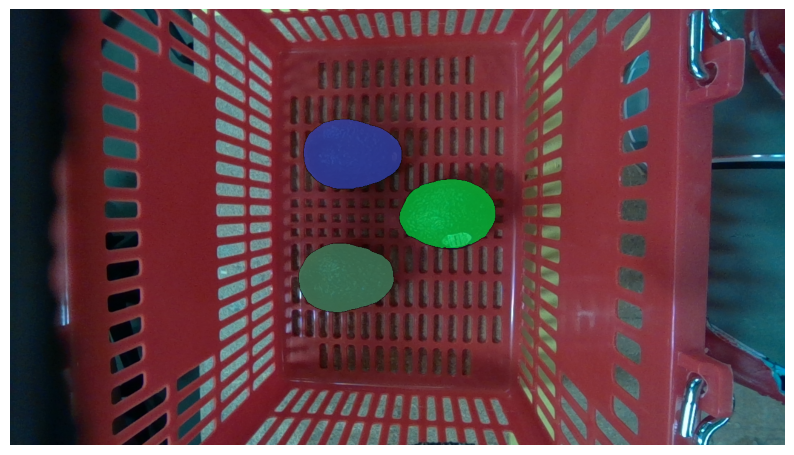

In [38]:
mask_sam.show_all_masks(np.array(rgbd_image.color))

In [43]:
# get first entry of tuple in boxes
b = [i[0] for i in label_vit.boxes]
l = label_vit.labels

(-0.5, 1279.5, 719.5, -0.5)

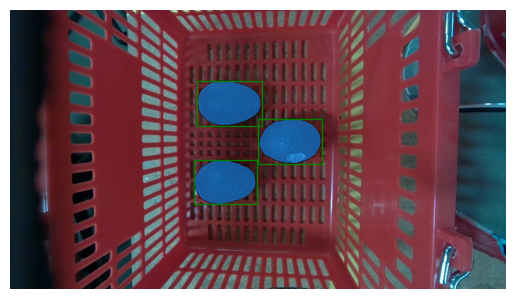

In [50]:
from PIL import Image, ImageDraw, ImageFont

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1))  


plt.imshow(rgbd_image.color)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
for box in b:
    show_box(np.array(box), plt.gca())
plt.axis('off')



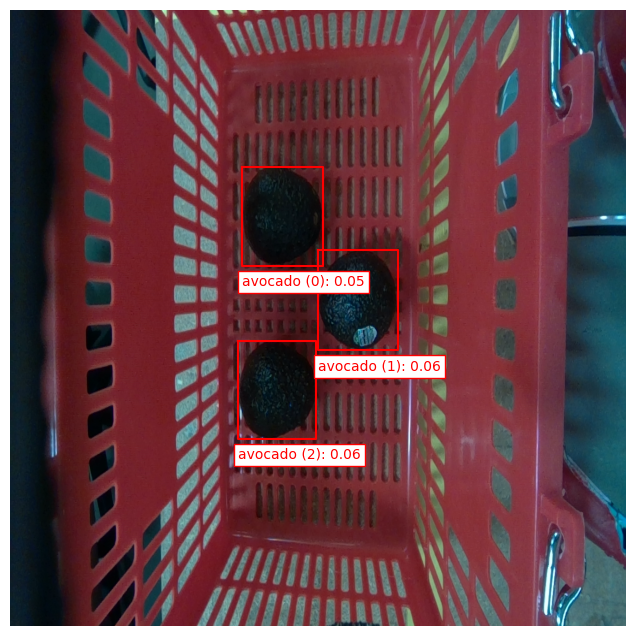

In [39]:
_, _ = label_vit.label(np.array(rgbd_image.color), queries, abbrevq, plot=True)

In [63]:
index = 0
rgbd_image, mcpcd, tmat, pca = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.98546151]


In [64]:
tmat

array([[ 0.98697494, -0.16045605, -0.01159015, -0.05734346],
       [-0.16008375, -0.97244122, -0.16950301,  0.03629804],
       [-0.01592704, -0.16915062,  0.98546151,  0.31724131],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [65]:
index = 1
rgbd_image, mcpcd1, tmat, pca1 = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.99064697]


In [66]:
tmat

array([[ 0.97236925,  0.23241679, -0.02191985, -0.00644827],
       [ 0.22748174, -0.96442416, -0.13467775, -0.04274227],
       [ 0.05244141, -0.12597013,  0.99064697,  0.30846284],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [67]:
index = 2
rgbd_image, mcpcd2, tmat, pca2 = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.98567079]


In [68]:
tmat

array([[ 0.98665647, -0.16180182, -0.01814324,  0.04438557],
       [-0.1565328 , -0.97333117,  0.16770185,  0.04194964],
       [ 0.04479385,  0.1626241 ,  0.98567079,  0.32025074],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
tmat, tmat[:3, 3]

(array([[ 0.98665647, -0.16180182, -0.01814324,  0.04438557],
        [-0.1565328 , -0.97333117,  0.16770185,  0.04194964],
        [ 0.04479385,  0.1626241 ,  0.98567079,  0.32025074],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([0.04438557, 0.04194964, 0.32025074]))

In [37]:
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])
o3d.visualization.draw_geometries([mcpcd, mcpcd1, mcpcd2, worldFrame, pca, pca1, pca2])